## NB: Start an ImageJ server before you run this!

```
git clone git://github.com/imagej/imagej-server
cd image-server
mvn -Pexec
```

In [1]:
import json
import os
import StringIO

import cellprofiler.image
import cellprofiler.measurement
import cellprofiler.object
import cellprofiler.pipeline
import cellprofiler.preferences
import cellprofiler.workspace
import imagej
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import skimage.io

/usr/local/miniconda3/envs/cellprofiler-notebooks/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def run_pipeline(pipeline_filename, image_dict):
    cellprofiler.preferences.set_headless()
    
    # Create and load the pipeline
    pipeline = cellprofiler.pipeline.Pipeline()
    pipeline.load(pipeline_filename)
    
    # Create the image set, and add the image data
    image_set_list = cellprofiler.image.ImageSetList()
    image_set = image_set_list.get_image_set(0)
    for image_name, input_pixels in image_dict.iteritems():
        image_set.add(image_name, cellprofiler.image.Image(input_pixels))
        
    # Persist the object set here (for now, see workspace TODO)
    object_set = cellprofiler.object.ObjectSet()

    # We can only run one group -- set the group index to 1.
    measurements = cellprofiler.measurement.Measurements()
    measurements.group_index = 1

    # Run the modules!
    for module in pipeline.modules():
        # Yes, we really do have to create a new workspace for each module
        # because the module attribute is required. Go team.
        workspace = cellprofiler.workspace.Workspace(
            image_set=image_set,
            image_set_list=image_set_list,
            measurements=measurements, 
            module=module,
            object_set=object_set, 
            pipeline=pipeline
        )
        
        module.prepare_run(workspace)
        module.run(workspace)
        module.post_run(workspace)
    
    # The workspace object has access to the measurements
    # and the image set/image set list which can be used
    # to use/view/store/whatever output data.
    return workspace


def objects2df(measurements, objects_name):
    features = measurements.get_feature_names(objects_name)
    
    n_features = len(features)
    n_objects = int(measurements.get_measurement("Image", "Count_{}".format(objects_name)))
    
    data = np.empty((n_objects, n_features))
    
    for feature_idx, feature in enumerate(features):
        data[:, feature_idx] = measurements.get_measurement(objects_name, feature)
    
    return pd.DataFrame(
        data=data,
        index=np.arange(1, n_objects + 1),
        columns=features
    )


def data2image(data):
    return Image.open(StringIO.StringIO(data))


def show(image):
    plt.imshow(image, interpolation='nearest', cmap='gray')
    plt.show()

In [3]:
ij = imagej.IJ()

img_id = ij.upload('data/images/1-162hrh2ax2.tif')

orig_png = ij.retrieve(img_id, format='png')
orig_pil = data2image(orig_png)
orig_np = np.array(orig_pil).copy()

script_eval = ij.find('ScriptEval')[0]

script = """
#@ CommandService commandService
#@ DisplayService displayService
#@both Img image
from net.imagej.plugins.commands.neigh import FindEdges
imageDisplay = displayService.createDisplay(image)
commandService.run(FindEdges, True, {'display': imageDisplay})
"""

_ = ij.run(script_eval, {'language': 'python', 'script': script, 'args': {'image': img_id}})

enhanced_png = ij.retrieve(img_id, format='png')
enhanced_pil = data2image(enhanced_png)
enhanced_np = np.array(enhanced_pil)

In [4]:
images = {
    'EnhancedGreen': enhanced_np,
    'OrigBlue': skimage.io.imread('data/images/1-162hrhoe2.tif'),
    'OrigGreen': orig_np
}

pipeline_filename = 'data/ExampleSpeckles.cppipe'

workspace = run_pipeline(pipeline_filename, images)

No handlers could be found for logger "cellprofiler.modules.exporttodatabase"
/usr/local/miniconda3/envs/cellprofiler-notebooks/lib/python2.7/site-packages/cellprofiler/utilities/hdf5_dict.py:527: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  np.issubdtype(hdf5_type, int) or
/usr/local/miniconda3/envs/cellprofiler-notebooks/lib/python2.7/site-packages/cellprofiler/utilities/hdf5_dict.py:529: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  hdf5_type_is_float = np.issubdtype(hdf5_type, float)
/usr/local/miniconda3/envs/cellprofiler-notebooks/lib/python2.7/site-packages/centrosome/cpmorphology.py:413: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will 

In [5]:
df = objects2df(workspace.measurements, "Nuclei")
df.head()

,Children_h2ax_Count,Intensity_IntegratedIntensityEdge_OrigBlue,Intensity_IntegratedIntensity_OrigBlue,Intensity_LowerQuartileIntensity_OrigBlue,Intensity_MADIntensity_OrigBlue,Intensity_MassDisplacement_OrigBlue,Intensity_MaxIntensityEdge_OrigBlue,Intensity_MaxIntensity_OrigBlue,Intensity_MeanIntensityEdge_OrigBlue,Intensity_MeanIntensity_OrigBlue,...,Mean_h2ax_Location_CenterMassIntensity_Y_OrigGreen,Mean_h2ax_Location_CenterMassIntensity_Z_OrigGreen,Mean_h2ax_Location_Center_X,Mean_h2ax_Location_Center_Y,Mean_h2ax_Location_Center_Z,Mean_h2ax_Location_MaxIntensity_X_OrigGreen,Mean_h2ax_Location_MaxIntensity_Y_OrigGreen,Mean_h2ax_Location_MaxIntensity_Z_OrigGreen,Mean_h2ax_Number_Object_Number,Number_Object_Number
1,2.0,6.313191,352.749708,0.017929,0.002747,0.787151,0.015625,0.031525,0.013845,0.020740,...,287.128718,0.0,760.201026,287.128718,0.0,759.000000,287.000000,0.0,1.500000,1.0
2,14.0,5.851698,343.493143,0.019028,0.003342,0.647997,0.015061,0.033371,0.013834,0.022287,...,353.571778,0.0,888.672008,353.571778,0.0,888.785714,353.785714,0.0,10.857143,2.0
3,3.0,7.736828,362.214925,0.016312,0.003342,3.141393,0.015808,0.031235,0.013742,0.019912,...,349.042839,0.0,445.787054,349.042839,0.0,445.666667,349.333333,0.0,11.666667,3.0
4,12.0,8.231449,374.368477,0.016419,0.003906,3.454832,0.015885,0.032914,0.013765,0.020390,...,498.056105,0.0,593.195713,498.056105,0.0,593.583333,497.833333,0.0,26.666667,4.0
5,2.0,6.446189,434.481806,0.019135,0.003494,3.068234,0.016205,0.033402,0.014075,0.022636,...,495.414352,0.0,236.648148,495.414352,0.0,236.000000,495.500000,0.0,25.500000,5.0


/usr/local/miniconda3/envs/cellprofiler-notebooks/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/miniconda3/envs/cellprofiler-notebooks/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


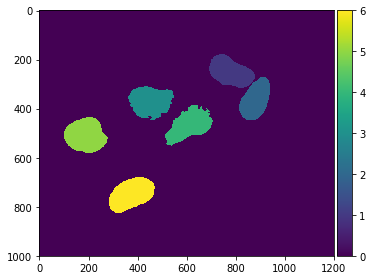

In [6]:
nuclei = workspace.object_set.get_objects("Nuclei")
skimage.io.imshow(nuclei.segmented)